In [1]:
import numpy as np
import os,random,shutil
np.random.seed(7)

In [2]:
# 为Keras模型准备数据集
#1，指定一些超参数：
FOLDER='E:\PyProjects\DataSet\Small_set_5_Class'
train_data_dir=os.path.join(FOLDER,'train')
val_data_dir=os.path.join(FOLDER,'test')
train_samples_num=400 # train set中全部照片数
val_samples_num=100
IMG_W,IMG_H,IMG_CH=150,150,3 # 单张图片的大小
batch_size=50 # 这儿要保证400和100能除断
epochs=50  # 用比较少的epochs数目做演示，节约训练时间
class_num=5 # 此处有5个类别

save_folder='E:\PyProjects\/DataSet\/FireAI\/DeepLearning\/FireAI009' # bottleneck特征保存位置

In [3]:
# 2，准备训练集，keras有很多Generator可以直接处理图片的加载，增强等操作，封装的非常好
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( # 单张图片的处理方式，train时一般都会进行图片增强
        rescale=1. / 255, # 图片像素值为0-255，此处都乘以1/255，调整到0-1之间
        shear_range=0.2, # 斜切
        zoom_range=0.2, # 放大缩小范围
        horizontal_flip=True) # 水平翻转

train_generator = train_datagen.flow_from_directory(# 从文件夹中产生数据流
    train_data_dir, # 训练集图片的文件夹
    target_size=(IMG_W, IMG_H), # 调整后每张图片的大小
    batch_size=batch_size,
    class_mode='categorical') # 此处是多分类问题，故而mode是categorical


Using TensorFlow backend.


Found 400 images belonging to 5 classes.


In [4]:
# 3，同样的方式准备测试集
val_datagen = ImageDataGenerator(rescale=1. / 255) # 只需要和trainset同样的scale即可，不需增强
val_generator = val_datagen.flow_from_directory(
        val_data_dir,
        target_size=(IMG_W, IMG_H),
        batch_size=batch_size,
        class_mode='categorical')

Found 100 images belonging to 5 classes.


In [5]:
# 4，构建模型
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import optimizers
from keras.models import Model
def build_model():
    base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=(IMG_W, IMG_H,IMG_CH))
    # 此处我们只需要卷积层不需要全连接层，故而inclue_top=False,一定要设置input_shape，否则后面会报错
    # 这一步使用applications模块自带的VGG16函数直接加载了模型和参数，作为我们自己模型的“身子”
    
    # 下面定义我们自己的分类器，作为我们自己模型的“头”
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:])) 
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(class_num, activation='softmax')) # 多分类问题
    
    top_model.load_weights(os.path.join(save_folder,'top_FC_model')) 
    # 上面定义了模型结构，此处要把训练好的参数加载进来，
    
    my_model = Model(inputs=base_model.input, outputs=top_model(base_model.output)) # 将“身子”和“头”组装到一起
    # my_model就是我们组装好的完整的模型，也已经加载了各自的weights
    
    # 普通的模型需要对所有层的weights进行训练调整，但是此处我们只调整VGG16的后面几个卷积层，所以前面的卷积层要冻结起来
    for layer in my_model.layers[:15]: # 15层之前都是不需训练的
        layer.trainable = False
        
    # 模型的配置
    my_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), # 使用一个非常小的lr来微调
                  metrics=['accuracy'])
    return my_model

In [6]:
# 开始用train set来微调模型的参数
print('start to fine-tune my model')
my_model=build_model()
history_ft = my_model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples_num // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_samples_num // batch_size)

start to fine-tune my model
Epoch 1/50
8/8 [==============================] - 124s 16s/step - loss: 0.0170 - acc: 0.9950 - val_loss: 0.2767 - val_acc: 0.9700
Epoch 2/50
8/8 [==============================] - 131s 16s/step - loss: 3.2684e-04 - acc: 1.0000 - val_loss: 0.2694 - val_acc: 0.9700
Epoch 3/50
8/8 [==============================] - 131s 16s/step - loss: 0.0175 - acc: 0.9950 - val_loss: 0.2593 - val_acc: 0.9700
Epoch 4/50
8/8 [==============================] - 131s 16s/step - loss: 0.0044 - acc: 0.9975 - val_loss: 0.2533 - val_acc: 0.9600
Epoch 5/50
8/8 [==============================] - 132s 17s/step - loss: 0.0079 - acc: 0.9975 - val_loss: 0.2558 - val_acc: 0.9600
Epoch 6/50
8/8 [==============================] - 145s 18s/step - loss: 0.0349 - acc: 0.9925 - val_loss: 0.2548 - val_acc: 0.9600
Epoch 7/50
8/8 [==============================] - 135s 17s/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.2620 - val_acc: 0.9500
Epoch 8/50
8/8 [==============================] - 136s 17s

In [7]:
# 画图，将训练时的acc和loss都绘制到图上
import matplotlib.pyplot as plt
%matplotlib inline
def plot_training(history):
    plt.figure(12)
    
    plt.subplot(121)
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(len(train_acc))
    plt.plot(epochs, train_acc, 'b',label='train_acc')
    plt.plot(epochs, val_acc, 'r',label='test_acc')
    plt.title('Train and Test accuracy')
    plt.legend()
    
    plt.subplot(122)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(train_loss))
    plt.plot(epochs, train_loss, 'b',label='train_loss')
    plt.plot(epochs, val_loss, 'r',label='test_loss')
    plt.title('Train and Test loss')
    plt.legend()
 
    plt.show()

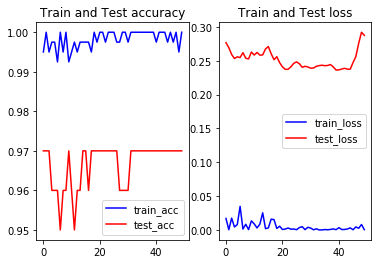

In [8]:
plot_training(history_ft)